Epoch 1/10


2024-05-16 11:28:10.890440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-16 11:28:11.056710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


    6/13512 [..............................] - ETA: 2:39 - loss: 0.6352 - accuracy: 0.7318   

2024-05-16 11:28:11.238158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13512/13512 [==============================] - ETA: 0s - loss: 0.0487 - accuracy: 0.9917

2024-05-16 11:30:28.780868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-16 11:30:28.841637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13512/13512 [==============================] - 151s 11ms/step - loss: 0.0487 - accuracy: 0.9917 - val_loss: 0.0261 - val_accuracy: 0.9962
Epoch 2/10
13512/13512 [==============================] - 132s 10ms/step - loss: 0.0470 - accuracy: 0.9919 - val_loss: 0.0254 - val_accuracy: 0.9962
Epoch 3/10
13512/13512 [==============================] - 131s 10ms/step - loss: 0.0469 - accuracy: 0.9919 - val_loss: 0.0253 - val_accuracy: 0.9962
Epoch 4/10
13512/13512 [==============================] - 132s 10ms/step - loss: 0.0469 - accuracy: 0.9919 - val_loss: 0.0252 - val_accuracy: 0.9962
Epoch 5/10
13512/13512 [==============================] - 132s 10ms/step - loss: 0.0469 - accuracy: 0.9919 - val_loss: 0.0253 - val_accuracy: 0.9962
Epoch 6/10
13512/13512 [==============================] - 132s 10ms/step - loss: 0.0468 - accuracy: 0.9919 - val_loss: 0.0252 - val_accuracy: 0.9962
Epoch 7/10
   1/4242 [..............................] - ETA: 17:05

2024-05-16 11:43:51.706792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-16 11:43:51.749842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4242/4242 [==============================] - 11s 3ms/step


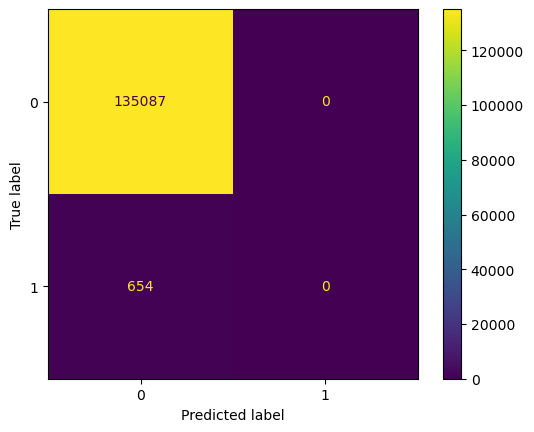

Final Test Accuracy: 0.9952
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    135087
           1       0.00      0.00      0.00       654

    accuracy                           1.00    135741
   macro avg       0.50      0.50      0.50    135741
weighted avg       0.99      1.00      0.99    135741



/Users/andrashertelendy/tensorflow-test/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrashertelendy/tensorflow-test/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrashertelendy/tensorflow-test/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

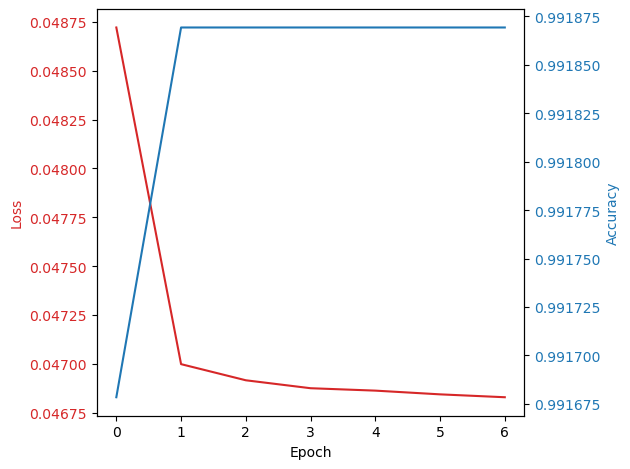

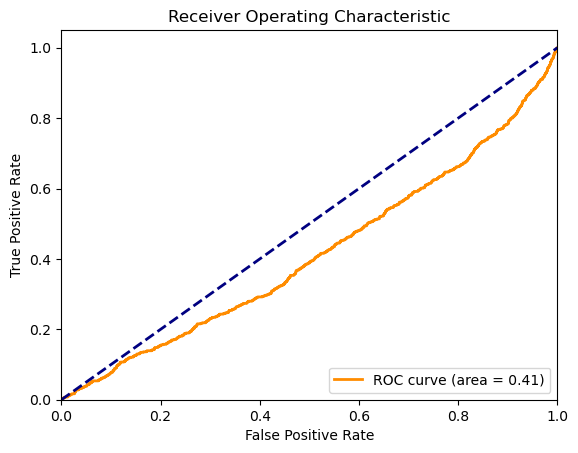

: 

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load data
files = [
    'Data/29_tracks_labeled.csv', 'Data/28_tracks_labeled.csv', 'Data/27_tracks_labeled.csv', 
    'Data/26_tracks_labeled.csv', 'Data/25_tracks_labeled.csv', 'Data/22_tracks_labeled.csv', 
    'Data/21_tracks_labeled.csv', 'Data/20_tracks_labeled.csv'
]
data = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

# Sort data by time if there's a timestamp column
data = data.sort_values(by=['frame'])

# Split data chronologically
train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Assuming the datasets have been properly labeled and contain the 'stopped_before_pedestrian' column
features_cols = ['xCenter', 'yCenter', 'xVelocity', 'yVelocity', 'xAcceleration', 'yAcceleration', 'lonVelocity', 'latVelocity', 'lonAcceleration', 'latAcceleration']

# Split features and labels for training data
X_train = train_data[features_cols]
y_train = train_data['stopped_before_pedestrian']

# Split features and labels for testing data
X_test = test_data[features_cols]
y_test = test_data['stopped_before_pedestrian']

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Compute class weights for resampled data
class_weights_resampled = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict_resampled = dict(enumerate(class_weights_resampled))

# Adjust the time steps to a larger value
time_steps = 10  # Adjust as needed based on the data

# Ensure the number of samples is a multiple of the time steps
num_samples = (X_train_resampled.shape[0] // time_steps) * time_steps
X_train_resampled = X_train_resampled[:num_samples]
y_train_resampled = y_train_resampled[:num_samples]

num_samples_test = (X_test.shape[0] // time_steps) * time_steps
X_test = X_test[:num_samples_test]

# Reshape y_test to match the number of sequences
y_test = np.array(y_test[:num_samples_test]).reshape((-1, time_steps))[:, 0]

# Reshape data for LSTM: [samples, time_steps, features]
X_train_resampled = X_train_resampled.reshape((-1, time_steps, X_train_resampled.shape[1]))
X_test = X_test.reshape((-1, time_steps, X_test.shape[1]))

# Build the LSTM model
model = Sequential([
    LSTM(25, input_shape=(time_steps, X_train_resampled.shape[2]), return_sequences=False),  # Reduced number of units
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=64, validation_split=0.2, class_weight=class_weight_dict_resampled, callbacks=[early_stopping])

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Print final accuracy and classification report
final_accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Final Test Accuracy: {final_accuracy:.4f}')
print(classification_report(y_test, y_pred_classes))

# Plot training loss and accuracy
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(history.epoch, history.history['loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(history.epoch, history.history['accuracy'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()